In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib 
import matplotlib.pyplot as plt
from numba import njit

Using numba is very useful to drastically speed up the process.  "Numba can be used to accelerate the Monte-Carlo simulation. The @njit decorator compiles the most computationally expensive functions (energy change, Metropolis update, equilibration, and sampling) into optimized machine code. Since the simulation requires millions of spin flips inside nested loops, pure Python would be too slow. Numba improves performance by 2–3 orders of magnitude, making it possible to run large systems (N≈10⁴–10⁵) and obtain statistically reliable results in reasonable time."


Initial average energy of the system 'random': -0.02
Initial average energy of the system 'up': 1.0
Initial magnetization of the system 'random': 0.02
Initial magnetization of the system 'up': 1.0
Change in energy from flipping a random spin: -4


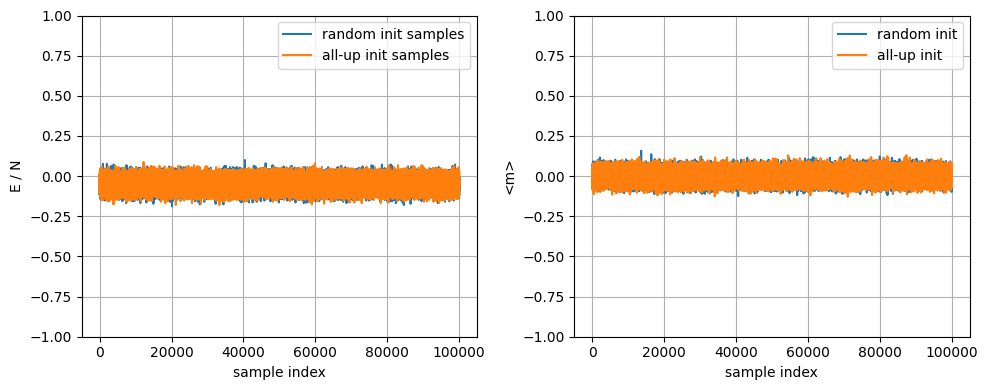

Random init: <E/N> = -0.0499, <m> = 0.0001
All-up init: <E/N> = -0.0499, <m> = -0.0002


In [11]:
np.random.seed(42)  # For reproducibility

kB = 1 #boltzmann constant set to 1 so the units are in energy (kB T)
N=1000
J=1
T=20
#spin_r = np.random.choice([-1,1], size=N) #spin initiale est random
#spin_u = np.ones(N, dtype=np.int32)

spin_r = np.random.choice([-1,1], size=N)#initial distribution is random

spin_u = np.ones(N, dtype=int)#initial distribution of the spins are all +1



#-----------------Première étape----------------:
#-----------------------------------------------:

@njit
def total_energy(spin,J=1):
    """Energie totale du système. 
    Si deux spins l'un à coté de l'autre sont dans le même sens, on compte +1 
    et s'ils sont de sens opposés, alors, -1
    INPUT: 
    J(constant) energy that determines the strength of the interaction (in our case = 1)
    spin: This is an array of length N of either -1 or +1 spins
    OUTPUT:
    E = the total energy of all the spins"""
    E = J* np.sum( spin* np.roll(spin,-1))#np.roll(spin, -1) sert à déplacer tout les spins de 1 donc = spin(i+1)
    return E
E = total_energy(spin_r)
print("Initial average energy of the system 'random':", E/N)

E2 = total_energy(spin_u)
print("Initial average energy of the system 'up':", E2/N)

@njit
def magnetization(spin):
    """ Il faut faire la moyenne entre les +1 et les -1
    INPUT:
    spin
    OUTPUT:
    M=the magnetization (adding all the +1 and -1 and dividing by the number of spins N)"""
    M = np.mean(spin)
    return M 

M = magnetization(spin_r)
print("Initial magnetization of the system 'random':", M)

M1 = magnetization(spin_u)
print("Initial magnetization of the system 'up':", M1)


@njit
def delta_E(spin, i, J=1):
    """ La différence d'énergie quand un spin au hasard (i) est échangé
    La formule viens de la multiplication entre E_i et E_f (sigma => s):
    E_i = J*(s_{i-1}s_i+s_is_{i+1})+c
    E_f = J*(-s_{i-1}s_i-s_is_{i+1})+c
    deltaE = -2*J*s_i*(s_{i-1}+s_{i+1})"""
    left = spin[(i-1)%N] #le %N sert à faire de la chaine un cycle. Quand i arrive à N, ça repart a 0.
    right = spin[(i+1)%N]
    delta_E = - 2 * J * spin[i] * (left + right)
    return delta_E


dE  = delta_E(spin_r, 7 , J)# i choisit au hasard par moi-même (7)
print("Change in energy from flipping a random spin:", dE)



#-----------------Deuxième étape----------------:
#-----------------------------------------------:

@njit
def Metropolis(spin, T, J=1):
    """ (On tourne un spin, si l'énergie diminue, on accepte l'échange,
     si l'énergie augmente, on accept l'échange avec une certaine probabilité
     qui dépend de la température)
     This function allows one metropolis step
     INPUT:
     spin = array of length N
     T = temperature
     i is a spin chosen at random 
     OUTPUT:
     -spin[i] (with a certain probability) """
    i = np.random.randint(0,N)
    dE= delta_E(spin,i, J=1)
    if dE <= 0 or np.random.random()<np.exp(-dE / T):
        spin[i]= -spin[i] #accepte toujours
        return True
    else:
        return False 
      

@njit
def equilibration(spin, T, J=1, sweeps=100):
    """ the equilibration funciton allows a first stability before the measurement of the first sample
     INPUT: 
     T = temperature
     J(constant) energy that determines the strength of the interaction (in our case = 1)
     spin: This is an array of length N of either -1 or +1 spins
     sweeps (parameter): This represents the number of times we do N * the metropolis step. Usually before we record our first sample.
     OUTPUT: 
     spin after an equilibration, when the samples are stabilized.
     """ #first step before the first measurement
    for _ in range(sweeps):
        for _ in range(N):
            Metropolis(spin, T, J)
    return spin


@njit
def monte_carlo_simulation(spin, T, J, step):
    """The function monte_carlo_simulation measures the energy and magnetization. 
    It records a sample, repeats the Metropolis 10*N times, and records the next sample.
    INPUT:
    spin, temperature, J
    step (parameter) = the number of recorded samples
    OUTPUT:
    Energy and magnetization at each recording (both are arrays of length "step")"""
    energies = np.zeros(step)
    mags = np.zeros(step)

    for s in range(step):
        for _ in range(10*N): #rule of thumb
            Metropolis(spin, T, J)
        energies[s] = total_energy(spin, J) / N #divided by N for the energy per spin (or the average)
        mags[s] = magnetization(spin)
    return energies, mags

spin_r1 = equilibration(spin_r, T, J, sweeps=100) #equilibration before recording
E_r_samples, m_r_samples = monte_carlo_simulation(spin_r1, T, J, step=100000) #recording of each sample
#E_r_samples[0]=E/N
#m_r_samples[0]=M

spin_u1 = equilibration(spin_u, T, J, sweeps=100)
E_u_samples, m_u_samples = monte_carlo_simulation(spin_u1, T, J, step=100000)
#E_u_samples[0] = E2/N
#m_u_samples[0] = M1

# Quick plotting of equilibration 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(E_r_samples, label='random init samples')
plt.plot(E_u_samples, label='all-up init samples')
plt.ylim(-1,1) #The energy can't go beyond 1 or -1 
plt.xlabel('sample index')
plt.ylabel('E / N')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(m_r_samples, label='random init')
plt.plot(m_u_samples, label='all-up init')
plt.ylim(-1,1) #Same as the energy but the magnetization will come close to 0 and without the limit it's harder to see the big picture 
plt.xlabel('sample index')
plt.ylabel('<m>')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Random init: <E/N> = {:.4f}, <m> = {:.4f}".format(E_r_samples.mean(), m_r_samples.mean())) #average magnetization and energy

print("All-up init: <E/N> = {:.4f}, <m> = {:.4f}".format(E_u_samples.mean(), m_u_samples.mean()))




When we use T=20 and N=1000, it seems like the curves don't stabilize completely, no matter how many steps we use. Even if we use an equilibration with a lot of sweeps, it seems like we will end up with these sharp up and down lines. Even though 20 is hot, we find that the energy ends up around -0.048 (when repeating the simulation a few times, i observed that the energy average is more around -0.05 with a higer imprecision then when N is set at 100000 or when the sampling is smaller then 100'000. See after). It is close to zero but it is still interesting to note as when the temperature approaches 0, the energy is closer to -1 and if its hotter like 2000 then it gets closer to 0. When N is bigger, the "mountains" flatten around -0.05. The magnetazation always approaches 0 no matter the temperature.

In [13]:

#-----------------Quatrième étape----------------:
#------------------------------------------------:

def specific_heat(E, T):
    """ E = Energie totale (array), T = température, <E> = moyenne de E
    <(laplacien E)^2> = <E^2>-<E>^2"""
    C_v = T**(-2) * (np.mean(E**2) - np.mean(E)**2)
    return C_v

C_v_r = specific_heat(E_r_samples, 10)
print(C_v_r)

#ou cette formule marche aussi

def specific_heat(E, T):
    return np.var(E, ddof=1) / T**2

C_v_r = specific_heat(E_r_samples, 10)
print(C_v_r)


9.948744270064001e-06
9.948843758501585e-06


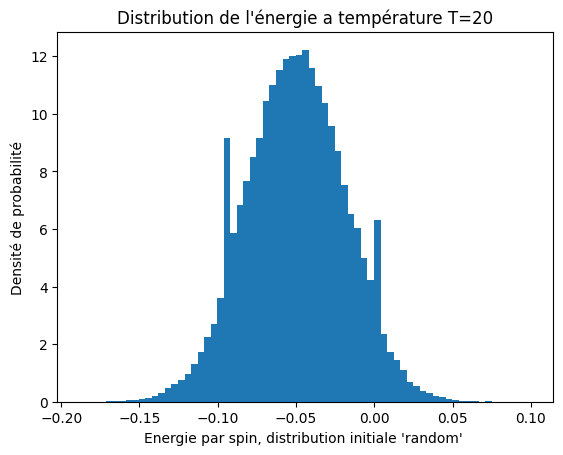

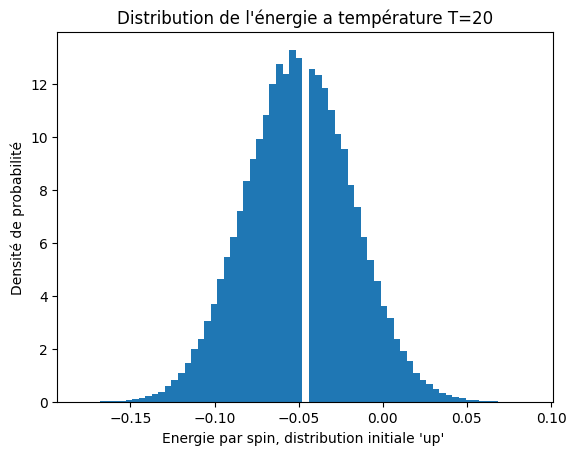

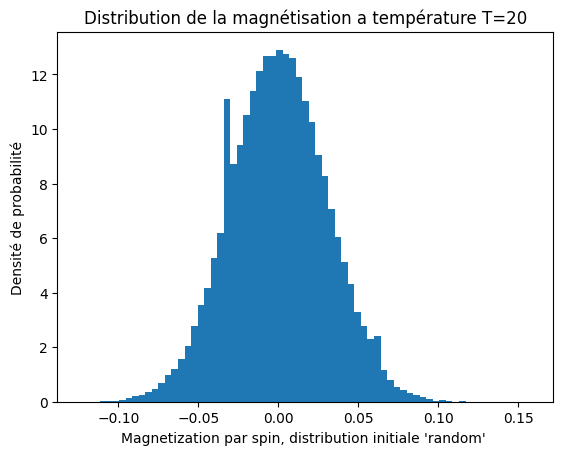

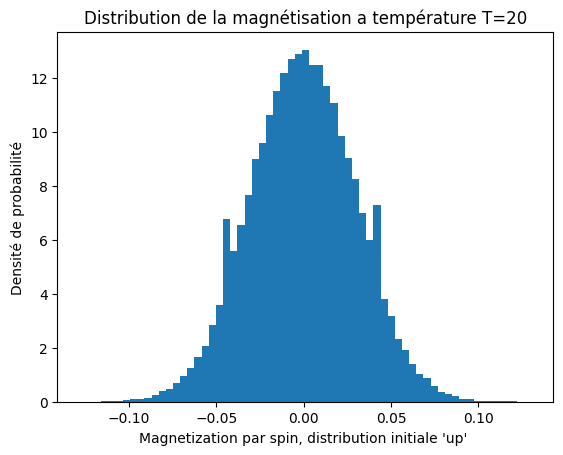

In [19]:

#-----------------Cinquième étape----------------:
#------------------------------------------------:






plt.hist(E_r_samples, bins=69, density=True)
plt.xlabel("Energie par spin, distribution initiale 'random' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de l'énergie a température T={T}")
plt.show()


plt.hist(E_u_samples, bins=69, density=True)
plt.xlabel("Energie par spin, distribution initiale 'up' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de l'énergie a température T={T}")
plt.show()


plt.hist(m_r_samples,bins=69, density=True)
plt.xlabel("Magnetization par spin, distribution initiale 'random' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de la magnétisation a température T={T}")
plt.show()

plt.hist(m_u_samples,bins=63, density=True)
plt.xlabel("Magnetization par spin, distribution initiale 'up' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de la magnétisation a température T={T}")
plt.show()


These can be considered as the ones at high temperatures (T=20). We already calculated the average in the very beginning right after the first graphs so we know the magnetization approximates around 0 and the energy will average around -0.05. If the density graphs show some spikes, it's just because of the number of bins. If there are too little there will be noise and if there are too many then there will be gaps.


The ones at a low temperature regime are below:


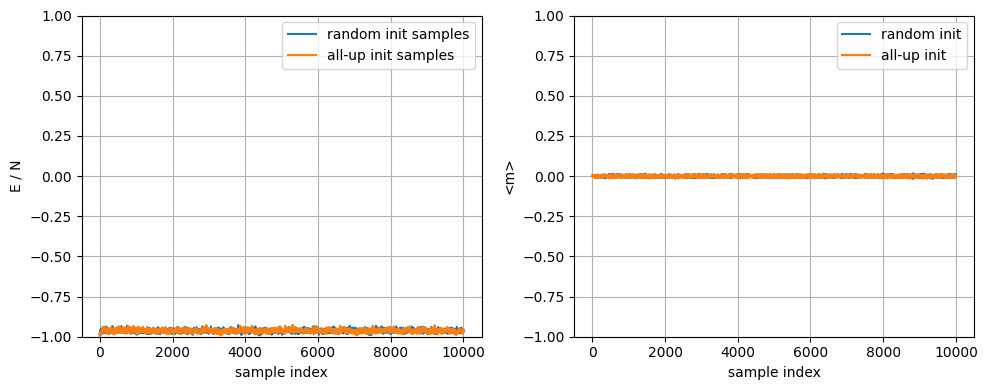

Random init: <E/N> = -0.9639, <m> = 0.0000
All-up init: <E/N> = -0.9640, <m> = -0.0001


In [ ]:

#-----------------Sixième étape------------------:
#------------------------------------------------:

T_c = 0.5 #cold temperature 
spin_r1 = equilibration(spin_r, T_c, J, sweeps=100)
E_r_samples_2, m_r_samples_2 = monte_carlo_simulation(spin_r1, T_c, J, step=10000)


spin_u1 = equilibration(spin_u, T_c, J, sweeps=100)
E_u_samples_2, m_u_samples_2 = monte_carlo_simulation(spin_u1, T_c, J, step=10000)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(E_r_samples_2, label='random init samples')
plt.plot(E_u_samples_2, label='all-up init samples')
plt.ylim(-1,1)
plt.xlabel('sample index')
plt.ylabel('E / N')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(m_r_samples_2, label='random init')
plt.plot(m_u_samples_2, label='all-up init')
plt.ylim(-1,1)
plt.xlabel('sample index')
plt.ylabel('<m>')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Random init: <E/N> = {:.4f}, <m> = {:.4f}".format(E_r_samples_2.mean(), m_r_samples_2.mean()))

print("All-up init: <E/N> = {:.4f}, <m> = {:.4f}".format(E_u_samples_2.mean(), m_u_samples_2.mean()))

I chose a cold temperature of 0.5 because 0.1 gives a straight line at -1 and the density graphs only have one column which I didn't find very visual. 

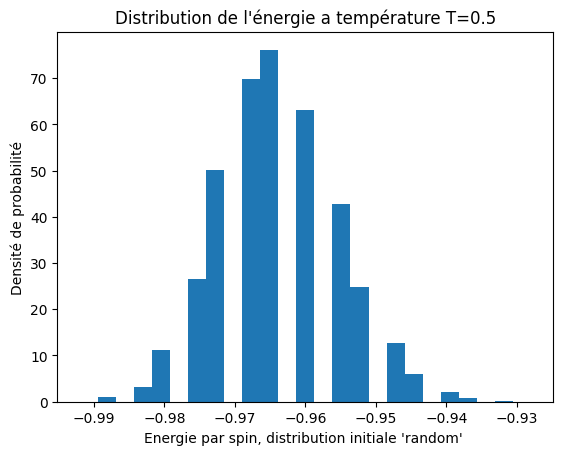

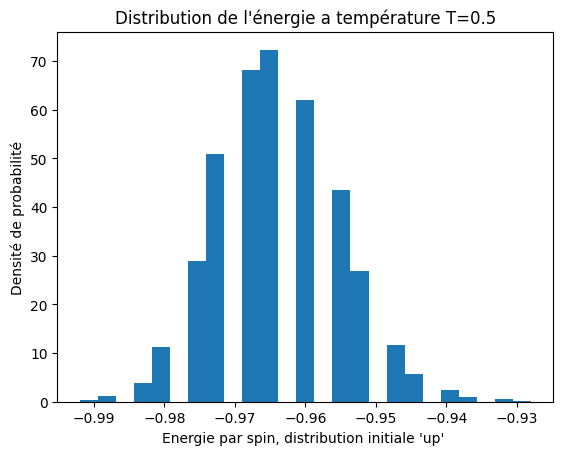

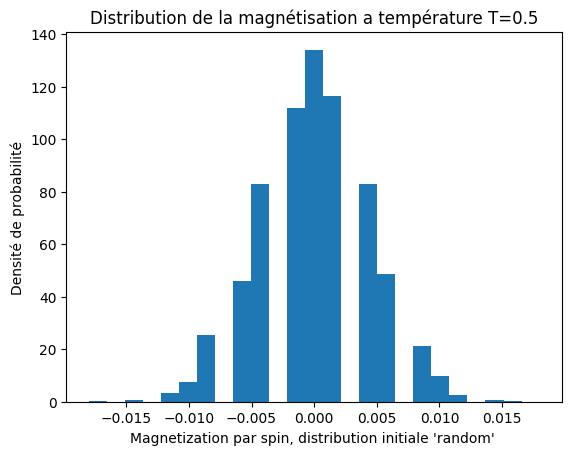

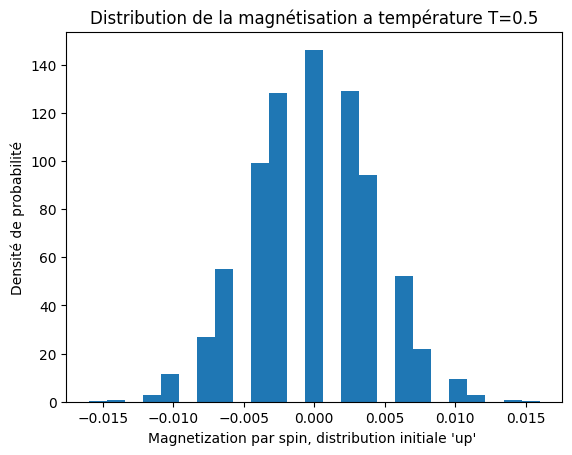

In [44]:
plt.hist(E_r_samples_2, bins=25, density=True)
plt.xlabel("Energie par spin, distribution initiale 'random' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de l'énergie a température T={T_c}")
plt.show()


plt.hist(E_u_samples_2, bins=25, density=True)
plt.xlabel("Energie par spin, distribution initiale 'up' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de l'énergie a température T={T_c}")
plt.show()


plt.hist(m_r_samples_2,bins=25, density=True)
plt.xlabel("Magnetization par spin, distribution initiale 'random' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de la magnétisation a température T={T_c}")
plt.show()

plt.hist(m_u_samples_2,bins=25, density=True)
plt.xlabel("Magnetization par spin, distribution initiale 'up' ")
plt.ylabel("Densité de probabilité")
plt.title(f"Distribution de la magnétisation a température T={T_c}")
plt.show()

We can see that the magnetization still goes towards 0, whereas the energy will be close to -1 no matter the initial distribution. The graphs with high temperature look the same when it comes to magnetization but look very different when it comes to the energy. When its hot, the energy averages around -0.05 and when its cold the energy will retrieve down to approximetaly -1

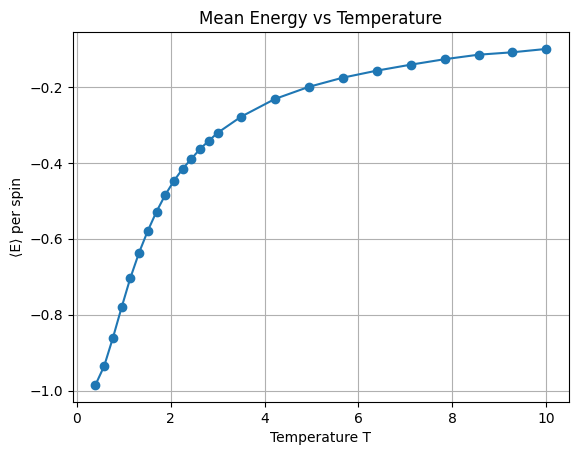

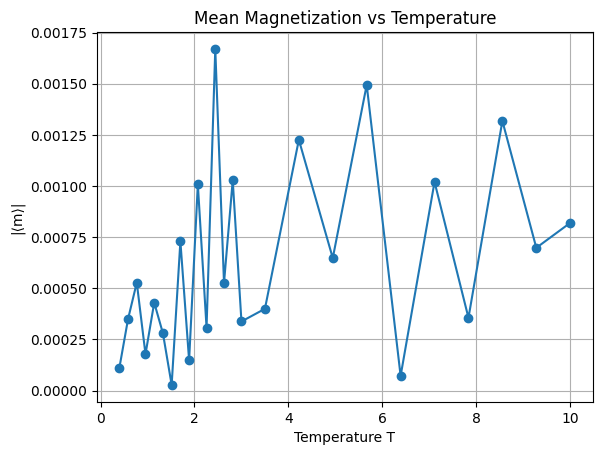

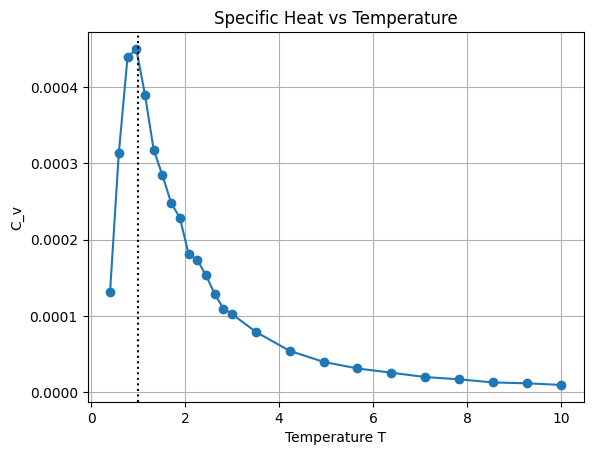

In [ ]:

#-----------------Septième étape------------------:
#-------------------------------------------------:

T_cold = np.linspace(0.4, 3, 15) # more happens at lower temperature, denser data
T_hot = np.linspace(3.5, 10, 10)   # less data when the temperature is hot, its less interesting
T_list = np.concatenate([T_cold, T_hot])



E_avg = []
M_avg = []
C_v_list = []

for T_3 in T_list:

    # fresh system each time, or start from previous state for efficiency
    spin = np.ones(N, dtype=np.int32)  # initial "up" configuration
    
    # equilibration
    equilibration(spin, T_3, sweeps=100)

    # sampling
    E_samples, M_samples = monte_carlo_simulation(spin, T_3, J=1, step=1000)

    # average energy per spin
    E_avg.append(np.mean(E_samples))

    # average magnetization per spin
    M_avg.append(np.mean(M_samples))

    # specific heat
    C_v = np.var(E_samples, ddof=1) / T_3**2
    C_v_list.append(C_v)

plt.plot(T_list, E_avg, 'o-')
plt.xlabel("Temperature T")
plt.ylabel("⟨E⟩ per spin")
plt.title("Mean Energy vs Temperature")
plt.grid(True)
plt.show()

plt.plot(T_list, np.abs(M_avg), 'o-')
plt.xlabel("Temperature T")
plt.ylabel("|⟨m⟩|")
plt.title("Mean Magnetization vs Temperature")
plt.grid(True)
plt.show()

plt.plot(T_list, C_v_list, 'o-')
plt.xlabel("Temperature T")
plt.axvline(1, color="black", linestyle = ":")
plt.ylabel("C_v")
plt.title("Specific Heat vs Temperature")
plt.grid(True)
plt.show()




The graphs are exactly as we can expect them to be. The first one correctly represents an increase in energy from -1 to 0. The graph for the magnetization remains at 0 undependently of the temperature. And the specific heat peaks around one and the decreases as temperature rises.